In [16]:
import numpy as np
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# A neural network with u_n， θ_c
# u_d = K(θ_c) u_n
# u_d(x) = \int K(x, y, θ_c) u_n(y) dy
class DirectKernelNet(nn.Module):

    def __init__(self, N_θ):
        super(DirectKernelNet, self).__init__()
        self.N_θ = N_θ
        # an affine operation: y = Wx + b
        
        self.fc1 = nn.Linear(N_θ + 2, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 20)
        self.fc4 = nn.Linear(20, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x



In [17]:
L = 1.0

# load data 
θ = np.load("uniform_direct_theta.npy")
κ = np.load("uniform_direct_K.npy")

N_data, N_θ =  θ.shape
N_x, N_y, N_data = κ.shape

# todo debug
N_data = 1


assert(N_x == N_y)
Δx = L/(N_x - 1)

input_train  = np.zeros((N_data * N_x * N_y, (N_θ + 2)), dtype=np.float32) # θ, x, y
output_train = np.zeros((N_data * N_x * N_y), dtype=np.float32)

xx = np.linspace(0, L, N_x)
Y, X = np.meshgrid(xx, xx)

# test
i = 20
j = 40
assert(X[i, j] == i*Δx and Y[i, j] == j*Δx)



for i in range(N_data):
    d_range = range(i*N_x*N_y, (i + 1)*N_x*N_y)
    input_train[d_range , 0:N_θ] = θ[i]
    input_train[d_range , N_θ] = X.reshape(-1)
    input_train[d_range , N_θ + 1] = Y.reshape(-1)
    
    output_train[d_range] = κ[:, :, i].reshape(-1)
    



x_train = torch.from_numpy(input_train) 
y_train = torch.from_numpy(output_train).unsqueeze(-1)



In [18]:
# preprocess the training data 

class DirectData(Dataset):

    def __init__(self, X, y):
        
        self.X = X if torch.is_tensor(X) else torch.from_numpy(X)
        self.y = y if torch.is_tensor(y) else torch.from_numpy(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

ds = DirectData(X=x_train, y=y_train)
ds = DataLoader(ds, batch_size=512, shuffle=True)



# training with adam
model = DirectKernelNet(N_θ)
loss_fn = torch.nn.MSELoss(reduction='sum')


learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

n_epochs = 50000
for epoch in range(n_epochs):
    
    for ix, (_x, _y) in enumerate(ds):
    
        
        # Forward pass: compute predicted y by passing x to the model.
        y_pred = model(_x)

        # Compute and print loss.
        loss = loss_fn(y_pred, _y)

        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable
        # weights of the model). This is because by default, gradients are
        # accumulated in buffers( i.e, not overwritten) whenever .backward()
        # is called. Checkout docs of torch.autograd.backward for more details.
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model
        # parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its
        # parameters
        optimizer.step()
        
    if epoch % 100 == 0:
        print("[{}/{}], loss: {}".format(epoch, n_epochs, np.round(loss.item(), 3)))
        

[0/50000], loss: 18410.541
[100/50000], loss: 10859.042
[200/50000], loss: 7777.036
[300/50000], loss: 5001.093
[400/50000], loss: 1810.953
[500/50000], loss: 1016.336
[600/50000], loss: 659.737
[700/50000], loss: 808.043
[800/50000], loss: 1256.167
[900/50000], loss: 956.422
[1000/50000], loss: 543.631
[1100/50000], loss: 386.779
[1200/50000], loss: 408.053
[1300/50000], loss: 328.021
[1400/50000], loss: 256.427
[1500/50000], loss: 234.317
[1600/50000], loss: 289.325
[1700/50000], loss: 175.032
[1800/50000], loss: 187.503
[1900/50000], loss: 347.64
[2000/50000], loss: 194.526
[2100/50000], loss: 787.368
[2200/50000], loss: 139.062
[2300/50000], loss: 105.038
[2400/50000], loss: 103.446
[2500/50000], loss: 158.701
[2600/50000], loss: 137.299
[2700/50000], loss: 316.371
[2800/50000], loss: 105.89
[2900/50000], loss: 167.731
[3000/50000], loss: 100.039
[3100/50000], loss: 104.686
[3200/50000], loss: 266.118
[3300/50000], loss: 187.749
[3400/50000], loss: 83.612
[3500/50000], loss: 163.79

[29700/50000], loss: 8.695
[29800/50000], loss: 9.25
[29900/50000], loss: 9.132
[30000/50000], loss: 9.679
[30100/50000], loss: 13.561
[30200/50000], loss: 11.822
[30300/50000], loss: 7.059
[30400/50000], loss: 7.083
[30500/50000], loss: 7.94
[30600/50000], loss: 8.29
[30700/50000], loss: 11.133
[30800/50000], loss: 8.044
[30900/50000], loss: 15.174
[31000/50000], loss: 9.806
[31100/50000], loss: 7.58
[31200/50000], loss: 7.339
[31300/50000], loss: 6.58
[31400/50000], loss: 10.724
[31500/50000], loss: 7.529
[31600/50000], loss: 8.43
[31700/50000], loss: 6.668
[31800/50000], loss: 7.446
[31900/50000], loss: 7.029
[32000/50000], loss: 5.718
[32100/50000], loss: 8.251
[32200/50000], loss: 9.81
[32300/50000], loss: 8.397
[32400/50000], loss: 8.342
[32500/50000], loss: 5.793
[32600/50000], loss: 8.439
[32700/50000], loss: 12.931
[32800/50000], loss: 6.414
[32900/50000], loss: 11.967
[33000/50000], loss: 17.792
[33100/50000], loss: 12.893
[33200/50000], loss: 6.077
[33300/50000], loss: 7.131

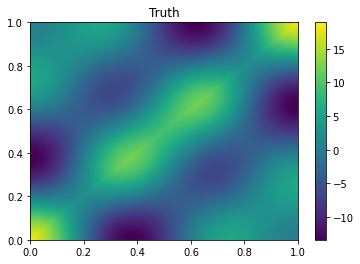

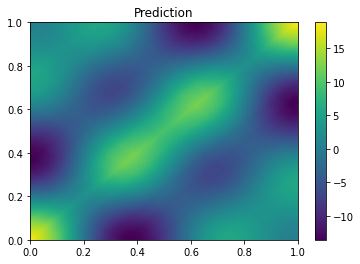

In [19]:
# test on training data

test_id = 0

input_test = np.zeros((N_x * N_y, (N_θ + 2)), dtype=np.float32) # θ, x, y
output_test = np.zeros((N_x * N_y), dtype=np.float32)

input_test[: , 0:N_θ] = θ[test_id]
input_test[: , N_θ] = X.reshape(-1)
input_test[: , N_θ+1] = Y.reshape(-1)
output_test = model(torch.from_numpy(input_test))
κ_pred = output_test.detach().numpy().reshape((N_x, N_y))

vmin, vmax = np.min(κ[:, :, test_id]), np.max(κ[:, :, test_id])
fig = plt.figure()
plt.pcolormesh(X, Y, κ[:, :, test_id], shading="gouraud")
plt.colorbar()
plt.title("Truth")
fig.savefig("Truth%i.png" % test_id)

fig = plt.figure()
plt.pcolormesh(X, Y, κ_pred, shading="gouraud")
plt.colorbar()
plt.title("Prediction")
fig.savefig("Prediction%i.png" % test_id)


In [10]:
i

0

In [67]:
# training with BFGS

model = DirectKernelNet(N_θ)
loss_fn = torch.nn.MSELoss(reduction='sum')

optimizer = torch.optim.LBFGS(model.parameters(), lr=0.8, max_iter=1000, line_search_fn='strong_wolfe')

for t in range(20):    
    def closure():
        optimizer.zero_grad()

        y_pred = model(x_train)

        # Compute and print loss.
        loss = loss_fn(y_pred, y_train)
        
        print(t, loss.item())
        
        loss.backward()
        return loss

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step(closure)
    

0 360947.125
0 361147.75
0 360830.9375
0 360830.6875
0 360832.21875
0 360830.375
0 360830.8125
0 360830.28125
0 360830.1875
0 360829.875
0 360829.875
1 360829.875
1 360829.90625
1 360829.875
1 360829.875
1 360829.875
1 360829.875
1 360829.875
2 360829.875
2 360829.90625
2 360829.875
2 360829.875
2 360829.875
2 360829.875
2 360829.875
3 360829.875
3 360829.90625
3 360829.875
3 360829.875
3 360829.875
3 360829.875
3 360829.875
4 360829.875
4 360829.90625
4 360829.875
4 360829.875
4 360829.875
4 360829.875
4 360829.875
5 360829.875
5 360829.90625
5 360829.875
5 360829.875
5 360829.875
5 360829.875
5 360829.875
6 360829.875
6 360829.90625
6 360829.875
6 360829.875
6 360829.875
6 360829.875
6 360829.875
7 360829.875
7 360829.90625
7 360829.875
7 360829.875
7 360829.875
7 360829.875
7 360829.875
8 360829.875
8 360829.90625
8 360829.875
8 360829.875
8 360829.875
8 360829.875
8 360829.875
9 360829.875
9 360829.90625
9 360829.875
9 360829.875
9 360829.875
9 360829.875
9 360829.875
10 360829.875

In [70]:

    
a = x_train.detach().numpy()
a   

array([[3.8422382e+01, 0.0000000e+00, 0.0000000e+00],
       [3.8422382e+01, 0.0000000e+00, 9.9999998e-03],
       [3.8422382e+01, 0.0000000e+00, 2.0000000e-02],
       ...,
       [3.8422382e+01, 1.0000000e+00, 9.8000002e-01],
       [3.8422382e+01, 1.0000000e+00, 9.9000001e-01],
       [3.8422382e+01, 1.0000000e+00, 1.0000000e+00]], dtype=float32)

In [64]:
θ.shape

(100, 1)